In [22]:
import nibabel as nib #pip install nibabel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import os.path as op
# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm
import os
from scipy.stats import zscore
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_prob_atlas
from nilearn import image
from nilearn.image import  resample_to_img
from sklearn.decomposition import PCA, FastICA

%matplotlib inline

https://openneuro.org/datasets/ds002322/versions/1.0.4  (alice)

https://openneuro.org/datasets/ds002739/versions/1.0.0  (autre)

In this project, we work with [the Alice dataset](https://openneuro.org/datasets/ds002322/versions/1.0.4). With the following functions, you will have the following folder's structure.
```
├───sub_18
│   ├───anat
│   ├───derivatives
│   └───func
├───sub_22
│   ├───anat
│   ├───derivatives
│   └───func
└───sub_35
    ├───anat
    ├───derivatives
    └───func
```

In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(dataset_id, dataset_version, subject_fmap):
    '''
    The called items should follow the following format:
    dataset_id = 'ds004226'
    dataset_version = '1.0.0'
    subject_fmap = '18'
    
    The dataset used for this mini-project can be found at the following link:
    https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    '''
    subject = 'sub-' + subject_fmap
    folder_name = ['anat', 'func', 'derivatives']
    file = [f'sub-{subject_fmap}_T1w.nii.gz', 
            f'sub-{subject_fmap}_task-alice_bold.nii.gz',
            f'sub-{subject_fmap}_task-alice_bold_preprocessed.nii.gz']
    
    paths = [[str(subject), str(folder_name[0]), str(file[0])],
            [str(subject), str(folder_name[1]), str(file[1])],
            [str(folder_name[2]), str(subject), str(file[2])]]
    
    # Because of the fact that the derivative folder requires a different link, we need to create this table, and we can't dynamically extract the folder's names
    # (again because of their differents positions), so we also need the table 'file'. If they all had the same, the code would be much shorter.
    
    path_subject = op.join(os. getcwd(), 'sub_'+subject_fmap)  
    
    if not op.isdir(path_subject): # If the subject's folder doesn't exists, we create it
        os.makedirs(path_subject)
    
    for i in range(len(folder_name)):
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, *paths[i])
        folders_path = op.join(path_subject, folder_name[i])
        if not os.path.exists(folders_path):  # if the folder doesn't already exists, we create it and download the corresponding content
            os.makedirs(folders_path) 
            print('Attempting download from ', download_link)
            download_url(download_link, op.join(folders_path, file[i]))
            print('Ok')



In [4]:
dataset_fmap = 'ds002322'
subject_fmap = ('18','22','35')

# Download one subject's data from each dataset
for i in subject_fmap:
    print('Starting the downloads for the subject sub-{}'.format(i))
    direct_file_download_open_neuro(dataset_id = dataset_fmap,
                                    dataset_version='1.0.0',
                                    subject_fmap = i)

Starting the downloads for the subject sub-18
Starting the downloads for the subject sub-22
Starting the downloads for the subject sub-35


### Load the data


In [5]:
current_directory = os.getcwd()
individual = '18'

# Load the data
img = nib.load(current_directory + '/sub_'+individual +'/derivatives/sub-'+individual+'_task-alice_bold_preprocessed.nii.gz')
data = np.asanyarray(img.dataobj)
print(data.shape)

(79, 95, 68, 372)


### Preprocess the data

In [6]:
# Extract the size of the data
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]
print(vol_shape, n_vols)

(79, 95, 68) 372


In [7]:
# Get the number of voxels
N = np.prod(vol_shape)

# We take the full matrix as time series
data_ = data.reshape(N, n_vols).T

# Reshape in function of the time axis and take the transpose
print(data_.shape)

(372, 510340)


In [8]:
# To get the PCA need the row means in a times_axis_shape x N
row_means = np.mean(data_, axis=1)
row_means = np.outer(row_means, np.ones(N))

# Substract the mean from the time axis
X = data_ - row_means

print("Mean of means left after centering: ", np.mean(np.mean(X, axis=1)))

Mean of means left after centering:  -9.983021225057745e-16


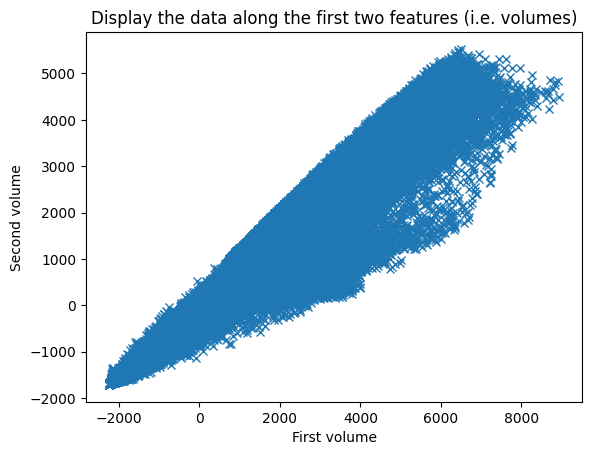

In [9]:
plt.plot(X[0], X[1], 'x')
plt.xlabel("First volume")
plt.ylabel("Second volume")
plt.title('Display the data along the first two features (i.e. volumes)')
plt.show()

### PCA 

In [10]:
# Compute the covariance matrix
covariance_matrix = np.cov(X)

# Get the U, S, VT matrices
U, S, VT = np.linalg.svd(covariance_matrix)

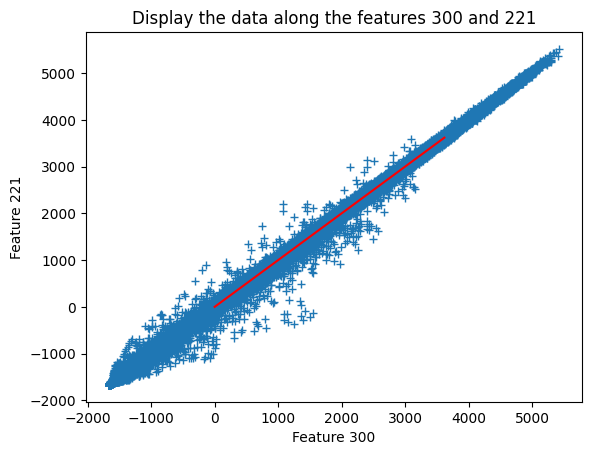

In [11]:
# Plot the signal in the first row against signal in the second row

# Choose which features to plot
feature1 = 300
feature2 = 221

plt.plot(X[feature1], X[feature2], '+')
scaled_u = U[:, 0] * -70000
plt.plot([0, scaled_u[feature1]], [0, scaled_u[feature2]], 'r')
plt.xlabel("Feature {}".format(feature1))
plt.ylabel("Feature {}".format(feature2))
plt.title('Display the data along the features {} and {}'.format(feature1, feature2))
plt.show()

In [12]:
# Scalar projection
C = U.T.dot(X)

C_vols = C.T.reshape(vol_shape + (n_vols,))

# Break 4D array in 3D
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]

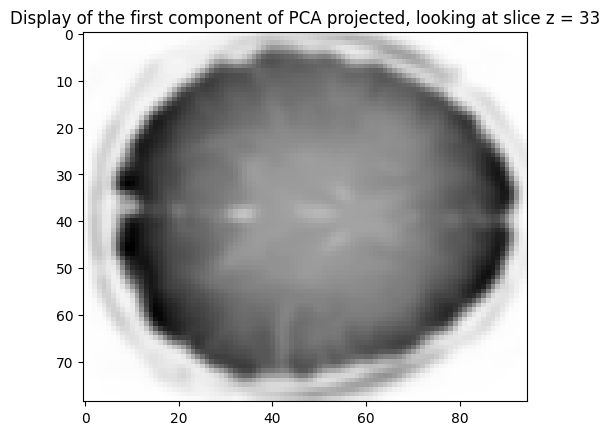

In [13]:
mid_z = int(vol0.shape[2]/2) - 1
plt.imshow(vol0[:, :, mid_z], cmap='gray')
plt.title("Display of the first component of PCA projected, looking at slice z = {}".format(mid_z))
plt.show()

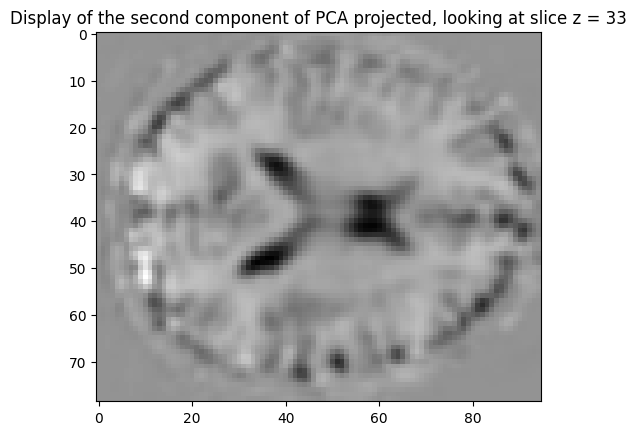

In [14]:
mid_z = int(vol1.shape[2]/2) - 1
plt.imshow(vol1[:, :, mid_z], cmap='gray')
plt.title("Display of the second component of PCA projected, looking at slice z = {}".format(mid_z))
plt.show()

### Spatial & Temporal ICA

Because we have only one stimulus lasting the whole experiment, it probably doesn't make any sense to look at the temporal ICA. (as it used to show when the brain is active or not basically)

### Group ICA

In [27]:
# Load first subject to use as basics for the next part
dataset_fmap = 'ds002322'
subject_fmap = ('18','22','35')

current_directory = os.getcwd()
individual = '18'
img = nib.load(current_directory + '/sub_'+individual +'/derivatives/sub-'+individual+'_task-alice_bold_preprocessed.nii.gz')

In [28]:
#find x,y,z shapes on functional data of first subject
affine = img.affine
print("Shape of image ", img.shape, "\n")
x,y,z,vol = img.shape

# Remove the first volumes of each subject to avoid false correlation
discarded_data = 5

N_vol = 372
N_subj = 3
N_tot = (N_vol-discarded_data)* N_subj

X = np.zeros((N_tot, x*y*z))
i = 0
n_nii = 0
nb_subj_counted = 0
for n_nii in range(N_subj):
    print('Loading subject ', n_nii+1)
    img = nib.load(current_directory + '/sub_'+subject_fmap[n_nii] +'/derivatives/sub-'+subject_fmap[n_nii]+'_task-alice_bold_preprocessed.nii.gz')
    data = np.asanyarray(img.dataobj)
    for j in range(N_vol-discarded_data):
        X[i] = data[:, :, :, j+discarded_data].reshape(x*y*z)
        i += 1
        
print("\n" + "Number of used vol ", int(X.shape[0]/N_subj))

print("\n" + "Finished loading ✅")

X = zscore(X, axis=1)
X = np.nan_to_num(X,0)


Shape of image  (79, 95, 68, 372) 

Loading subject  1
Loading subject  2
Loading subject  3

Number of used vol  367

Finished loading ✅


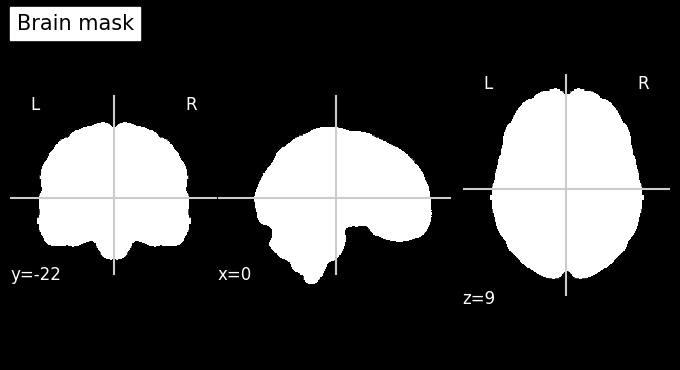

In [29]:
icbms = datasets.fetch_icbm152_2009()
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, title='Brain mask',black_bg=True, colorbar=False)

In [30]:
S_dict = {}
n_components = [10, 20, 40]

for i in n_components:
    
    n2=2*i
    print('Running PCA with n = %d components 💁‍♂️'%n2)
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)
    print('Running FastICA with n = %d components 🏃'%i)

    ica = FastICA(n_components=i,random_state=1)
    S_ = ica.fit_transform(H)

    S_dict[i]=S_
    print('Done ✌️')

Running PCA with n = 80 components 💁‍♂️
Running FastICA with n = 40 components 🏃
Done ✌️


In [31]:
# Loading T1 image as a background
T1_img = icbms.t1 

Plotting for n = 40 components


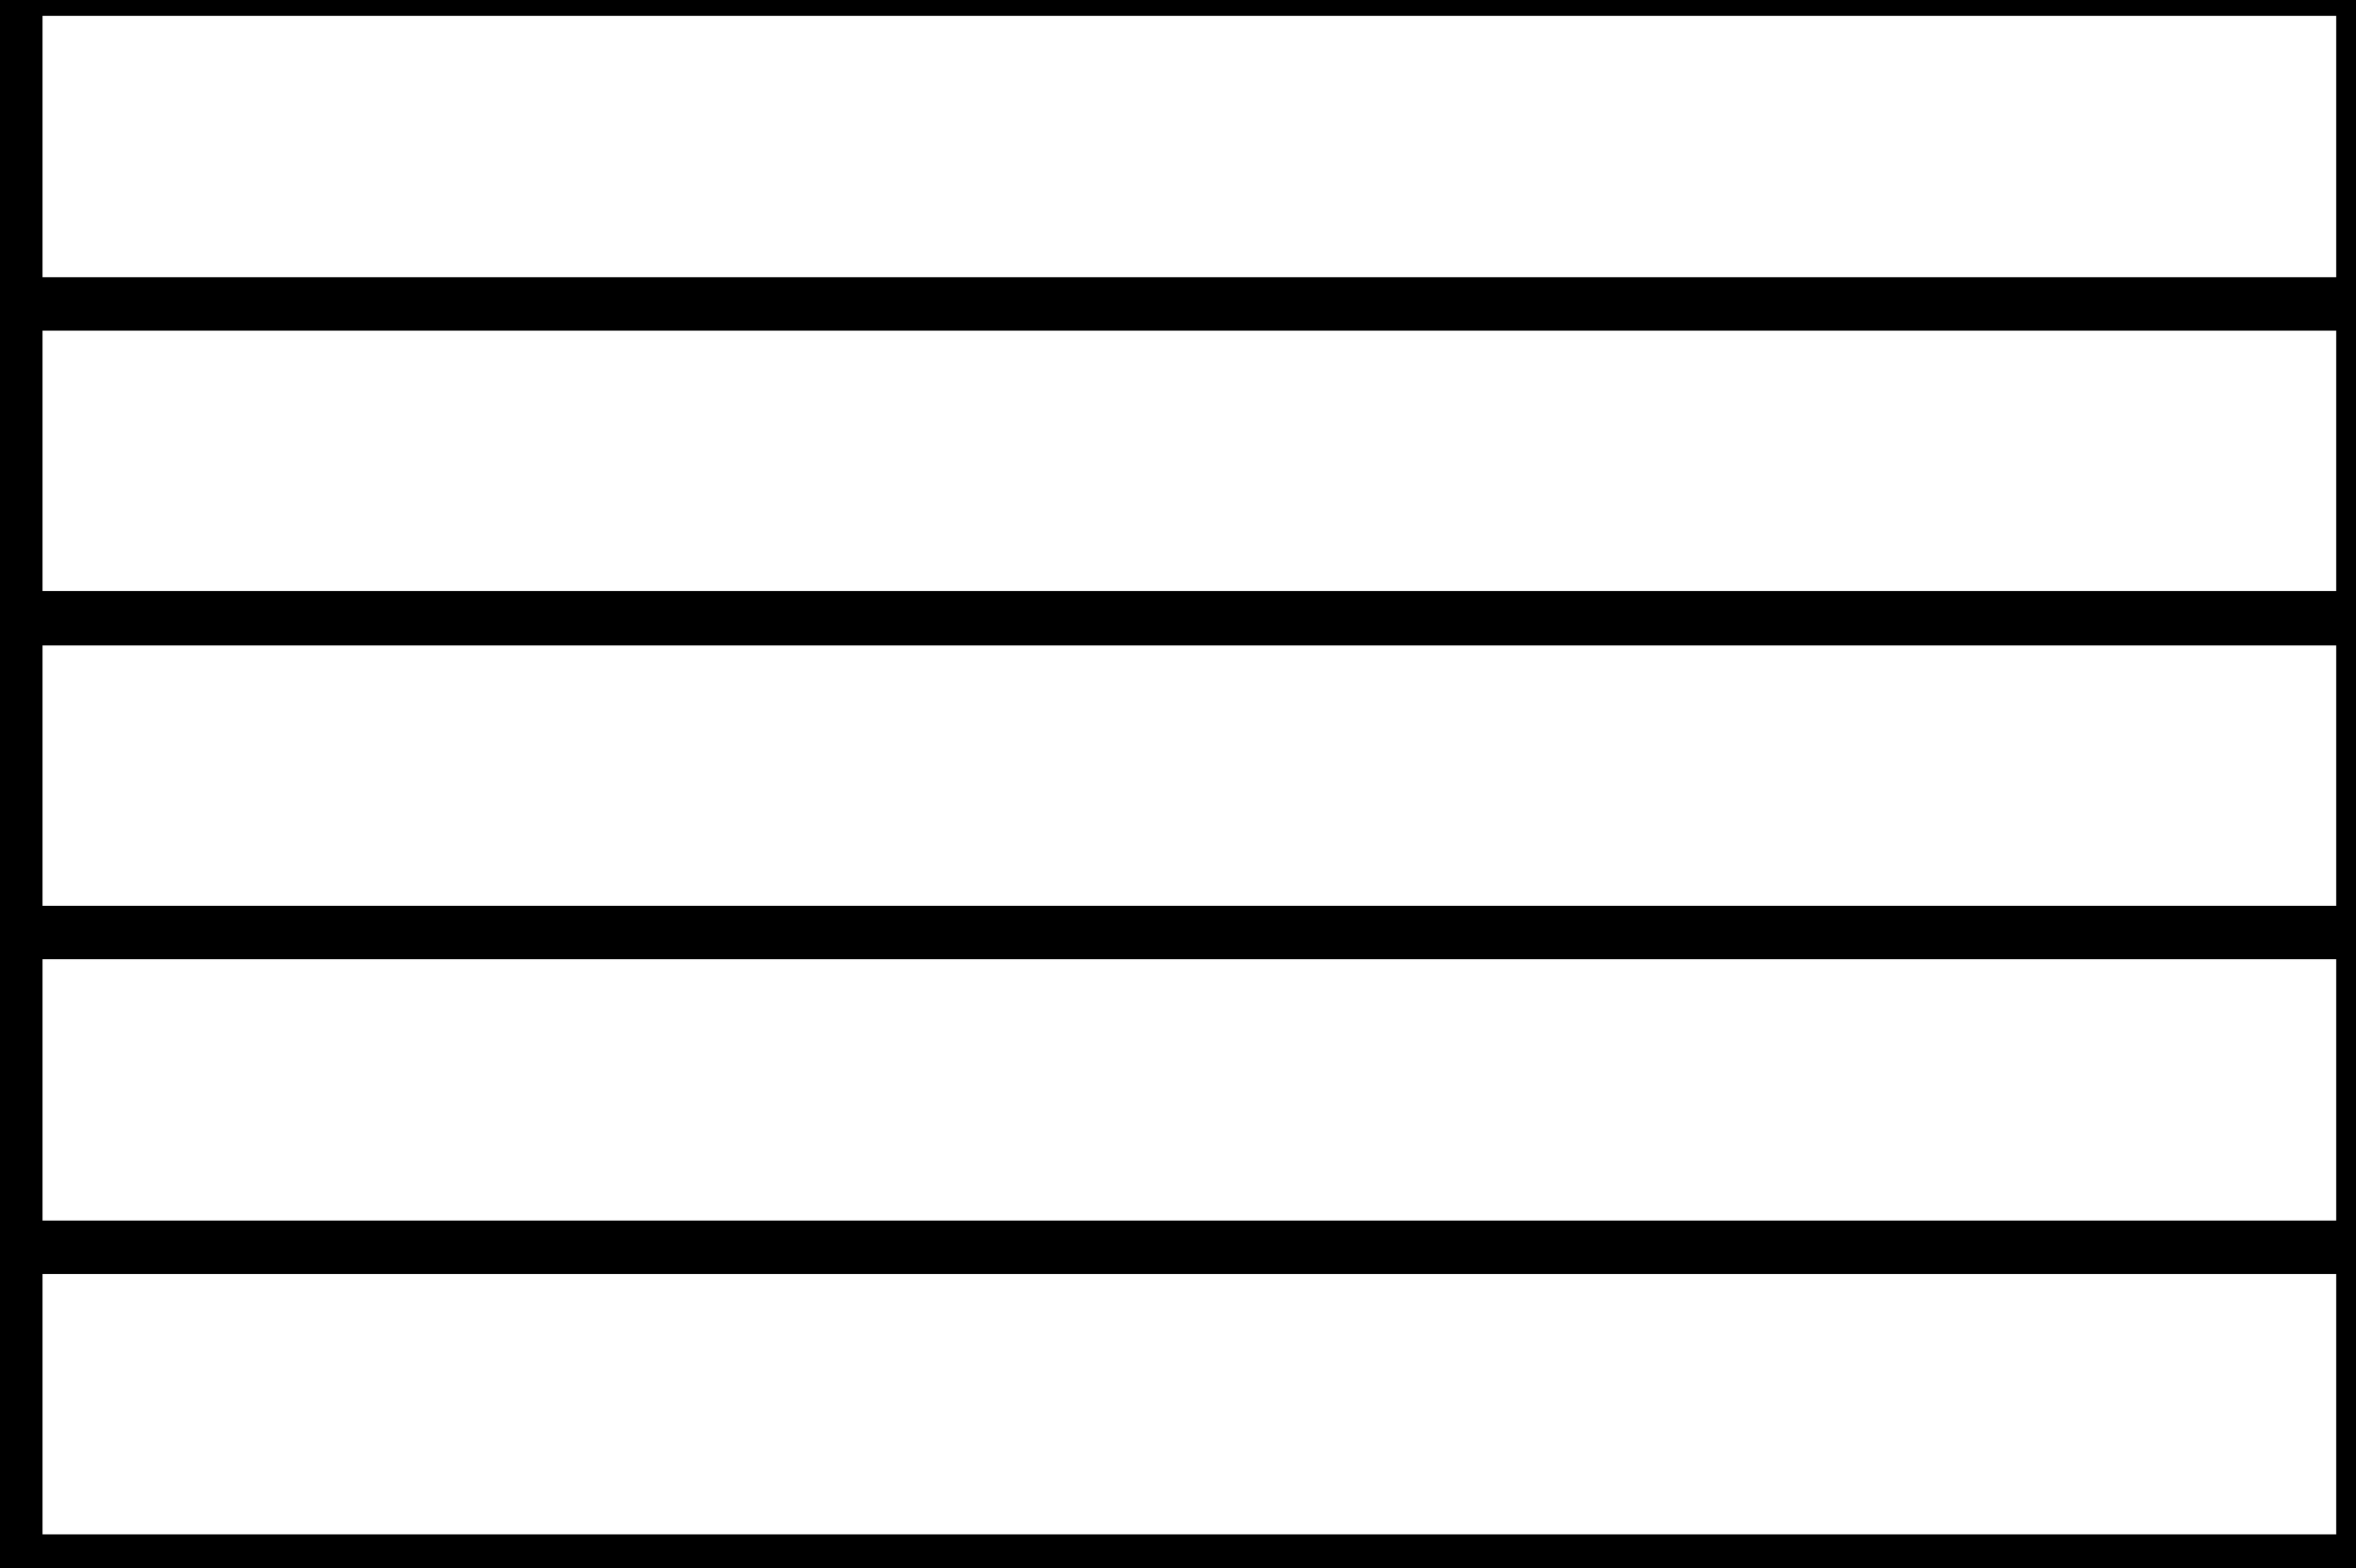

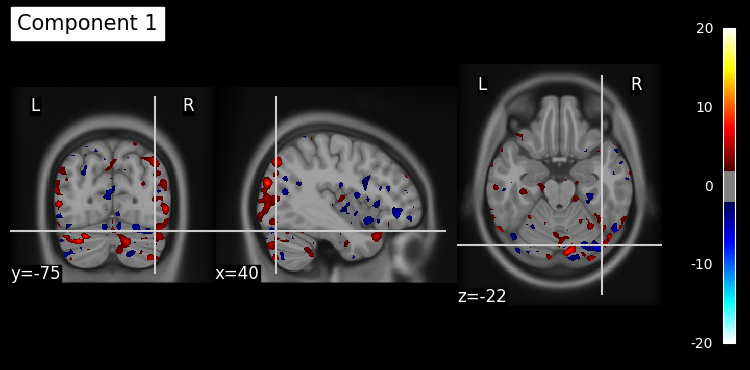

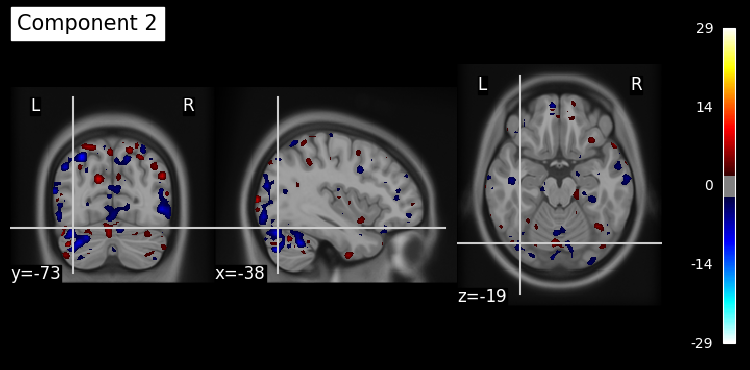

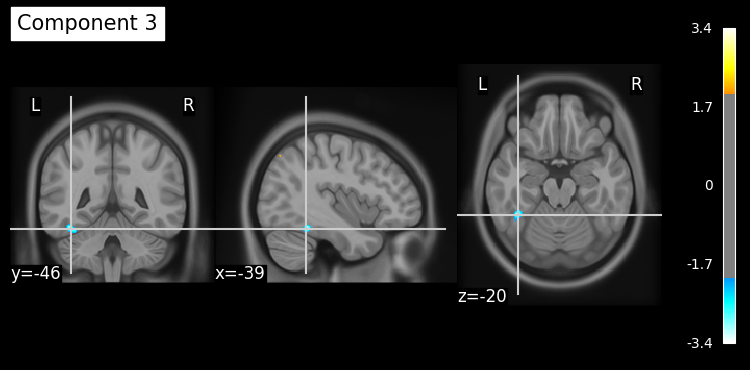

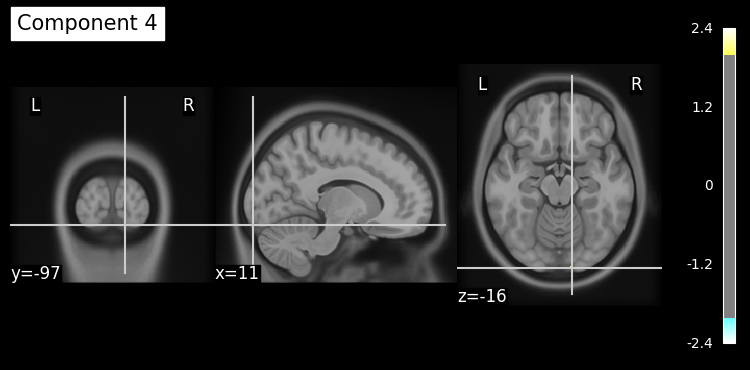

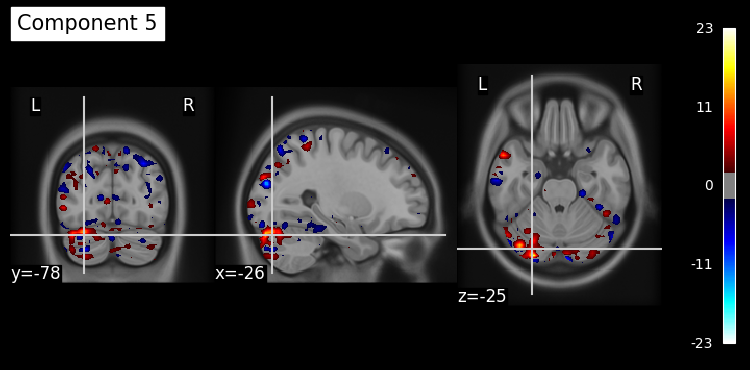

In [34]:
# Plot the ground level components for the different number of components, limited to the first 5 components
n_row = 5
fig, axes = plt.subplots(nrows = n_row, ncols = len(n_components),figsize=(30, 20), facecolor="k", edgecolor="k") 
# gs = gridspec.GridSpec(n_row, 3, width_ratios=[1, 1, 1])

for j, i in enumerate(n_components):
    print('Plotting for n = %d components'%i)
    axes[0, j].set_title('%d components'%i, fontsize=20, color="white")
    S_ = S_dict[i].copy()
    for idx, s in enumerate(S_.T[:(min(n_row, S_.T.shape[0]))]):
        s_img = nib.Nifti1Image(s.reshape(x,y,z), affine)
        s_img_resampled = resample_to_img(s_img, T1_img, interpolation='linear')
        data_mask = masker.fit_transform(s_img_resampled)
        masked = masker.inverse_transform(data_mask)
        plot_stat_map(masked, title='Component %d'%(idx+1),black_bg=True, colorbar=True, bg_img=T1_img, display_mode='ortho', threshold=2*np.std(s), axes=axes[idx, j])

In [28]:
atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")

In [48]:
atlas.labels

['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallo

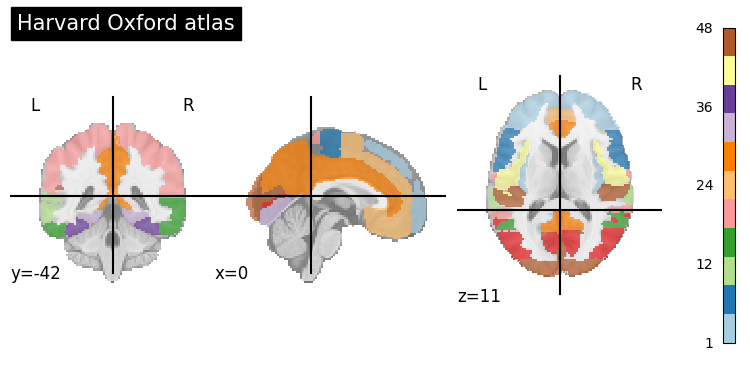

In [36]:
plot_roi(datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm").filename, title="Harvard Oxford atlas", colorbar=True, cmap='Paired')

In [40]:
msdl_atlas = datasets.fetch_atlas_msdl()


Dataset created in C:\Users\arthu/nilearn_data\msdl_atlas



 ...done. (1 seconds, 0 min)
Extracting data from C:\Users\arthu/nilearn_data\msdl_atlas\01a216f54c9220cf2626a4d2eebe3981\MSDL_rois.zip..... done.


In [44]:
for idx in range(len(msdl_atlas.labels)):
    print(idx, msdl_atlas.labels[idx])

0 L Aud
1 R Aud
2 Striate
3 L DMN
4 Med DMN
5 Front DMN
6 R DMN
7 Occ post
8 Motor
9 R DLPFC
10 R Front pol
11 R Par
12 R Post Temp
13 Basal
14 L Par
15 L DLPFC
16 L Front pol
17 L IPS
18 R IPS
19 L LOC
20 Vis
21 R LOC
22 D ACC
23 V ACC
24 R A Ins
25 L STS
26 R STS
27 L TPJ
28 Broca
29 Sup Front S
30 R TPJ
31 R Pars Op
32 Cereb
33 Dors PCC
34 L Ins
35 Cing
36 R Ins
37 L Ant IPS
38 R Ant IPS


0: left auditory cortex
1: right auditory cortex
20: visual cortex

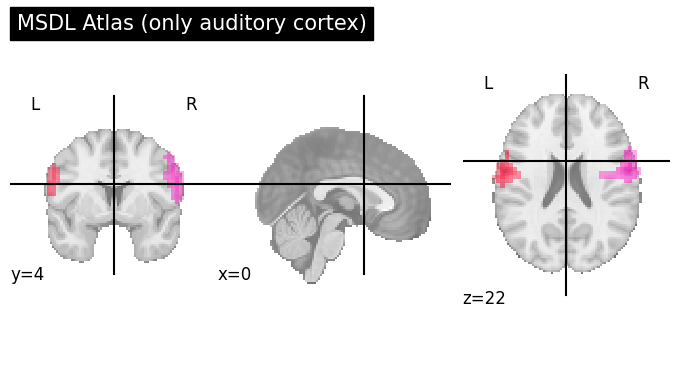

In [55]:
roi_msdl_atlas = image.index_img(msdl_atlas.maps, [0,1])
plot_prob_atlas(roi_msdl_atlas, title='MSDL Atlas (only auditory cortex)')

From this Atlas reference image and the 5th component of the 40 components ICA, we can see that the auditory cortices (left and right) are stimulated, since the stimuli is and audio file, we can assume that ICA detected a activation response on the auditory cortices. 

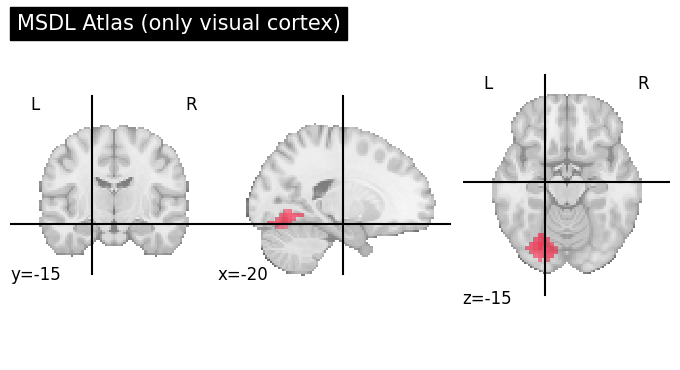

In [66]:
roi_msdl_atlas = image.index_img(msdl_atlas.maps, [20])
plot_prob_atlas(roi_msdl_atlas, title='MSDL Atlas (only visual cortex)', cut_coords=(-20, -15, -15))

From this Atlas reference image that shows the visual cortex, and from the 1st component of the 40 components ICA, we can see that the visual cortex is stimulated. We could imagine that the subject's visual cortex was indeed activated since listening to a audiobook can induce internal imaginary visualisation of the story.

In [44]:
nb_comp_timecourse = 10

S_ = S_dict[40].copy()

associated_timecourse = list()

for cidx in range(nb_comp_timecourse):
    threshold = np.std(S_[:, cidx])
    s_comp = np.reshape(S_[:, cidx], (x, y, z))
    thresh_mask = s_comp > threshold
    
    t_comp = X.reshape(N_tot, x, y, z)[:, thresh_mask].mean(axis=1)
    associated_timecourse.append(t_comp)

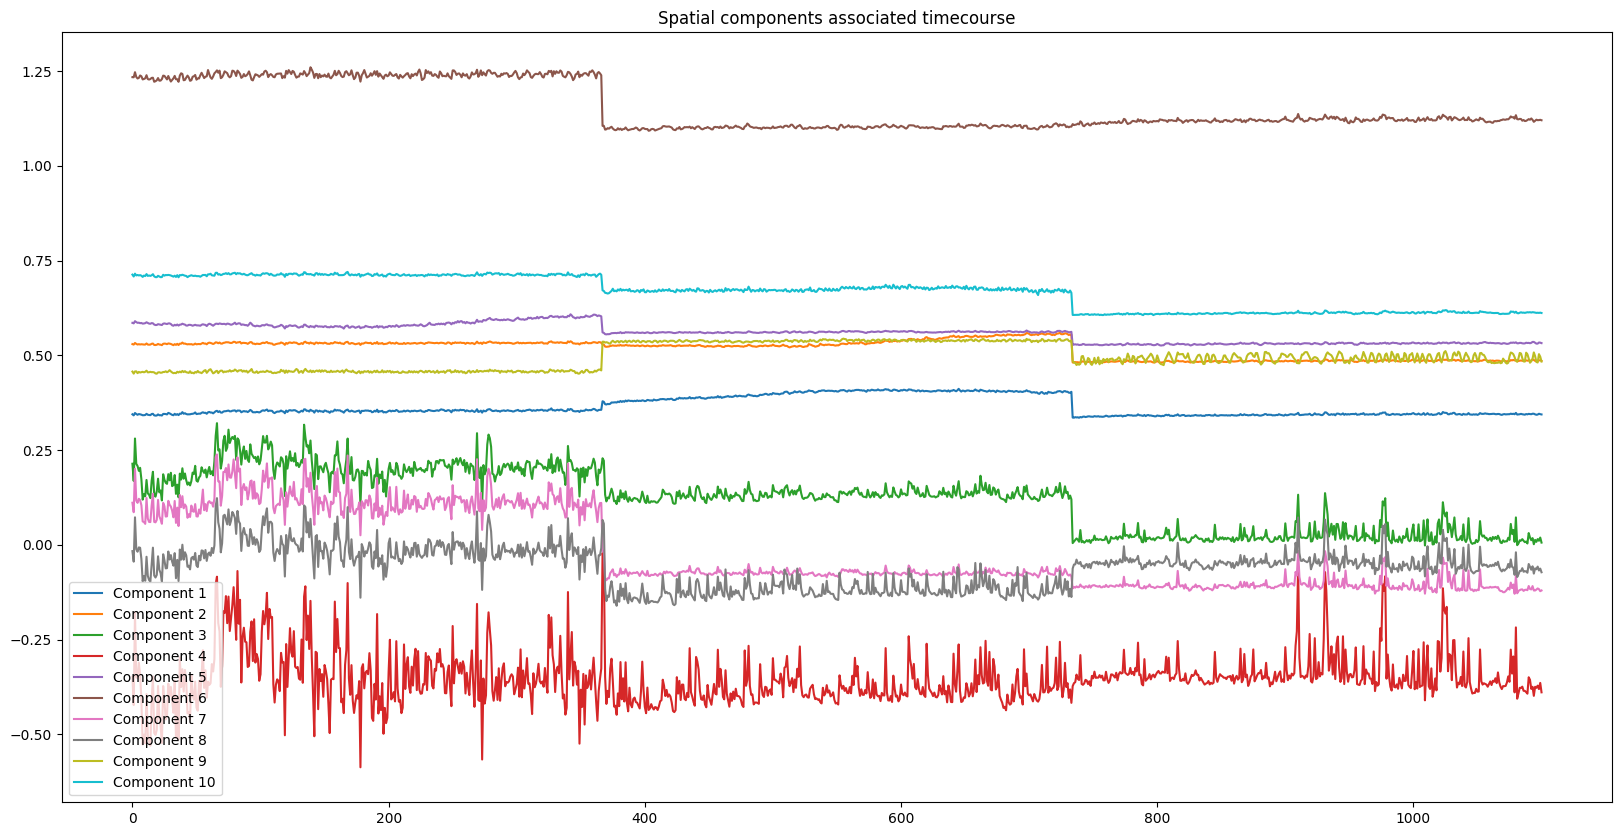

In [45]:
fig, ax = plt.subplots(1, figsize=(20, 10))
for cidx in range(nb_comp_timecourse):
    ax.plot(associated_timecourse[cidx], label='Component %d'%(cidx+1))
    
ax.legend()
ax.set_label('TR')
ax.set_title('Spatial components associated timecourse')
plt.show()

If it looks like noise it is probably noise and can be used to denoise the data

# Seed analysis

In [68]:
# Get data from the first subject
current_directory = os.getcwd()
individual = '18'
img = nib.load(current_directory + '/sub_'+individual +'/derivatives/sub-'+individual+'_task-alice_bold_preprocessed.nii.gz')
data = np.asanyarray(img.dataobj)

# Remove first 5 volumes because they are some weird artifacts
data = data[..., 5:]

print(data.shape)

(79, 95, 68, 367)


!!! TODO: Choose a voxel from the auditory or visual cortex --> get the coordinates via fsleyes

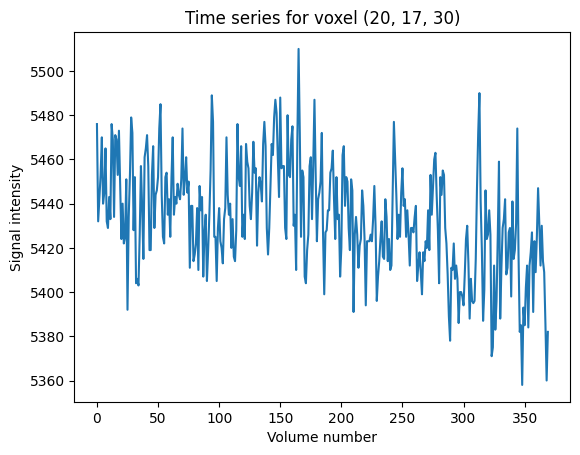

In [80]:
# Choose one voxel
voxel_x = 20
voxel_y = 17
voxel_z = 30
voxel_time_series = data[voxel_x, voxel_y, voxel_z, 2:] # We remove the first 2 volumes because they are an artifact

plt.plot(voxel_time_series)
plt.xlabel("Volume number")
plt.ylabel("Signal intensity")
plt.title("Time series for voxel ({}, {}, {})".format(voxel_x, voxel_y, voxel_z))
plt.show()

In [82]:
pearson_coeffs = np.zeros(data.shape[:-1])

# Go through all the voxels and compute the Pearson correlation coefficient
for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        for z in range(data.shape[2]):
            pearson_coeffs[x, y, z] = np.corrcoef(voxel_time_series, data[x, y, z, 2:])[0, 1] # remove the first 2 volumes to have equal data shape

c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
c:\Users\arthu\anaconda3\envs\nssp\lib\site-packages\nilearn\image\resampling.py:663: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(


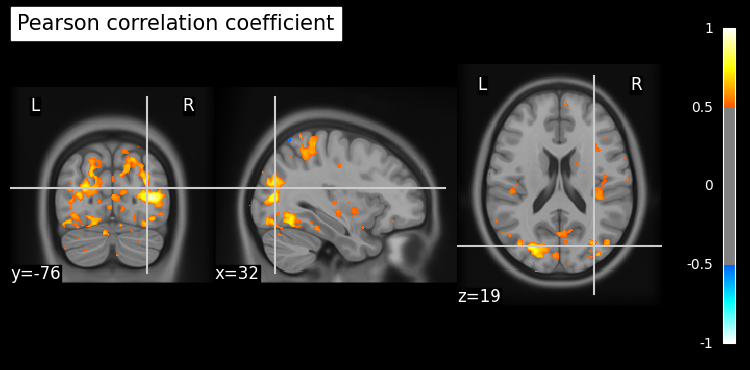

In [83]:
s_img = nib.Nifti1Image(pearson_coeffs, affine)
data_to_show = masker.fit_transform(s_img)
masked = masker.inverse_transform(data_to_show)
plot_stat_map(masked, title='Pearson correlation coefficient',black_bg=True, colorbar=True, bg_img=T1_img, display_mode='ortho', threshold=0.5)

In [85]:
pearson_coeffs.shape

(79, 95, 68)

ValueError: x must have 2 or fewer dimensions

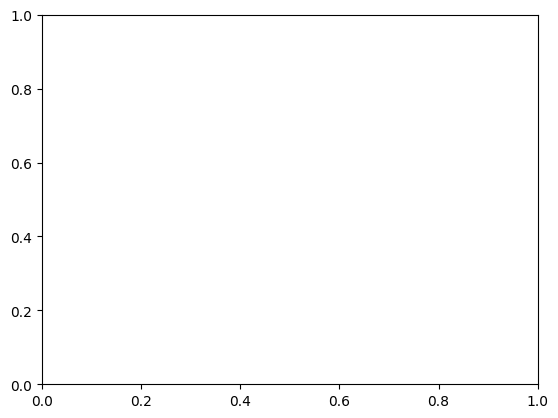

In [84]:
# Plot the histogram of the Pearson correlation coefficients
plt.hist(pearson_coeffs, bins=100)
plt.xlabel("Pearson correlation coefficient")
plt.ylabel("Number of voxels")
plt.title("Histogram of Pearson correlation coefficients")
plt.show()